# Problem Statement

We are going to use various machine learning algorithms to predict if an offer is going to be clicked.

# Data Discovery

## 1.  Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
sns.set(style='darkgrid', palette='terrain')

In [2]:
# Load database
engine = create_engine('sqlite:///merged.db')
# Load table
merged = pd.read_sql_table("merged", con=engine)
merged.head()

,offer_id,lead_uuid,apr,lender_id,requested,loan_purpose,credit,annual_income,clicked_at
0,810117850,ae2d5046-a7c7-44fe-b6f4-cde3d8bf29e2,199.00,1103,500.00,debt_consolidation,fair,72000.00,NaT
1,810119030,b12fbb06-1402-4de3-a91f-fb6360ff85e4,249.00,1103,500.00,debt_consolidation,poor,29724.00,NaT
2,810122970,a119a3db-ab14-46fc-acd1-35cf20dec1ec,249.00,1103,500.00,debt_consolidation,poor,60000.00,NaT
3,810124218,3166d6bd-1c79-44c0-867c-889afd35990c,17.69,240,50000.00,debt_consolidation,good,139000.00,NaT
4,810124220,3166d6bd-1c79-44c0-867c-889afd35990c,17.19,240,50000.00,debt_consolidation,good,139000.00,NaT


In [3]:
# Display shape of the data
merged.shape

(458939, 9)

## 2. Check Data Quality

### Check for null values

In [4]:
merged.isnull().sum()/len(merged)

offer_id        0.00
lead_uuid       0.00
apr             0.00
lender_id       0.00
requested       0.00
loan_purpose    0.00
credit          0.00
annual_income   0.00
clicked_at      0.98
dtype: float64

The missing values in "clicked_at" prepresent the offers that were never clicked. So we will fill missing values with 0. 
There is only a tiny percentage of data missing for "apr", "requested" and "annual income". We will delete the rows that contains those missing data.


### Check for duplicated values

In [5]:
merged.duplicated().sum()

0

There are no duplicated entries in the dataset.

## 3. Data Preprocessing

### Fill in the missing values for "clicked_at"

In [6]:
merged['clicked_at'] = merged['clicked_at'].fillna(0)

In [7]:
merged.head()

,offer_id,lead_uuid,apr,lender_id,requested,loan_purpose,credit,annual_income,clicked_at
0,810117850,ae2d5046-a7c7-44fe-b6f4-cde3d8bf29e2,199.00,1103,500.00,debt_consolidation,fair,72000.00,0
1,810119030,b12fbb06-1402-4de3-a91f-fb6360ff85e4,249.00,1103,500.00,debt_consolidation,poor,29724.00,0
2,810122970,a119a3db-ab14-46fc-acd1-35cf20dec1ec,249.00,1103,500.00,debt_consolidation,poor,60000.00,0
3,810124218,3166d6bd-1c79-44c0-867c-889afd35990c,17.69,240,50000.00,debt_consolidation,good,139000.00,0
4,810124220,3166d6bd-1c79-44c0-867c-889afd35990c,17.19,240,50000.00,debt_consolidation,good,139000.00,0


### Replace timestamps with value "1"

Timestamps in "clicked_at" represent the offers that were clicked. In order to feed the data to machine learning algorithms, we will replace timestamps with value 1.

In [8]:
merged['clicked_at'] = merged['clicked_at'].apply(lambda x: 0 if x==0 else 1)

In [9]:
# Display to see if replacement is done successfully
merged[merged['clicked_at']==1]

,offer_id,lead_uuid,apr,lender_id,requested,loan_purpose,credit,annual_income,clicked_at
15,810124210,3166d6bd-1c79-44c0-867c-889afd35990c,17.69,363,50000.00,debt_consolidation,good,139000.00,1
61,810156067,4a0b5fc1-d876-4309-af75-469d8e728831,249.00,1103,500.00,debt_consolidation,poor,27456.00,1
96,810119592,68d29157-a80f-4f93-9c44-06aa267e0fb1,18.14,363,5000.00,home_improvement,excellent,75000.00,1
177,810134455,8e09f7ce-638e-4289-b42f-77b1ef5672d2,25.50,363,5000.00,debt_consolidation,poor,97000.00,1
206,810147006,9365008b-9e94-4d0a-882f-d2c8e04c266e,149.00,1777,5000.00,large_purchases,poor,90000.00,1
...,...,...,...,...,...,...,...,...,...
458800,813007969,1cfb7ca4-40a9-4c25-800e-47e24d8e985e,159.99,383,1000.00,home_improvement,poor,50500.00,1
458855,813015608,74b5a97d-9db7-494d-b45a-e790626ffb57,98.79,321,1000.00,other,good,36000.00,1
458901,813048319,326ea6e1-5e3e-4203-bfe0-a409ee3b2305,21.10,327,500.00,debt_consolidation,poor,72000.00,1
458918,813059139,bd4f3bcc-9999-4634-9f06-5a6279475321,0.36,2108,5000.00,home_improvement,good,35000.00,1


### Remove missing data for other columns

In [10]:
# drop missing data
merged = merged.dropna()

In [11]:
# check to make sure there are no other missing data in the dataset
merged.isnull().sum()

offer_id         0
lead_uuid        0
apr              0
lender_id        0
requested        0
loan_purpose     0
credit           0
annual_income    0
clicked_at       0
dtype: int64

## 4. Balance the dataset

### Check the distribution of target variable

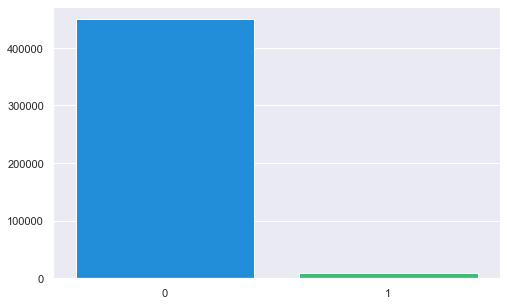

In [12]:
# plot distribution of the target variable
target_counts = merged['clicked_at'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(target_counts.index, target_counts.values)

Looks like we have way more uncliked offers than clicked offers. When one set of classes dominate over another set of classes, it causes the machine learning model to be more biased towards majority class which results in poor classification of minority classes.

Now, there are various approaches to deal with this problem. For example:

***Undersampling methods***

***Oversampling methods***

***Synthetic data generation***

We will use undersampling method in this project.

In [13]:
non_clicked_df = merged[merged['clicked_at']==0] # a dataframe with uncliked offers
clicked_df = merged[merged['clicked_at']==1] # a dataframe with clicked offers

In [14]:
# random sampling from non_clicked_df
# the final length of this dataframe will be the same as clicked_df
non_clicked_df = non_clicked_df.sample(1 * len(clicked_df))

In [15]:
# display shape
non_clicked_df.shape

(9316, 9)

In [16]:
# concatenated non_clicked_df and clicked_df
merged = pd.concat([non_clicked_df, clicked_df], axis=0)
merged.shape

(18632, 9)

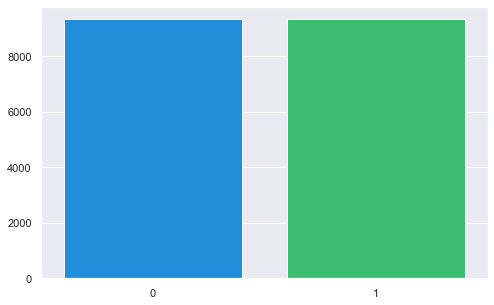

In [17]:
# plot distribution of the target variable
target_counts = merged['clicked_at'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(target_counts.index, target_counts.values)

Now the classes are more balanced than before.

## 5. Exploratory Data Analysis

In [18]:
features = merged[['offer_id', 'apr', 'lender_id', 'requested', 'annual_income']]
target = merged['clicked_at']

### Summary Statistics

In [19]:
# display 
merged.describe()

,offer_id,apr,lender_id,requested,annual_income,clicked_at
count,18632.00,18632.00,18632.00,18632.00,18632.00,18632.00
mean,811594937.84,84.39,888.37,8227.48,69403.26,0.50
std,852097.25,80.43,665.91,13002.62,139791.99,0.50
min,810116813.00,0.19,237.00,1.00,0.00,0.00
25%,810866299.25,22.21,327.00,1000.00,36000.00,0.00
50%,811563547.50,34.00,417.00,4500.00,55000.00,0.50
75%,812339339.25,149.00,1777.00,10000.00,78000.00,1.00
max,813069359.00,557.85,2139.00,250000.00,11111111.00,1.00


In [20]:
# display dataframe info
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18632 entries, 44488 to 458929
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   offer_id       18632 non-null  int64  
 1   lead_uuid      18632 non-null  object 
 2   apr            18632 non-null  float64
 3   lender_id      18632 non-null  int64  
 4   requested      18632 non-null  float64
 5   loan_purpose   18632 non-null  object 
 6   credit         18632 non-null  object 
 7   annual_income  18632 non-null  float64
 8   clicked_at     18632 non-null  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 1.4+ MB


In [21]:
# change 'offer_id' to object
merged['lender_id'] = merged['lender_id'].astype('object')
merged['lender_id'].dtype

dtype('O')

In [22]:
def plot_box_dist(df, col):
    ''' 
    Makes s boxplot and a distribution plot side by side.
    
    Args:
    
    df(dataframe): pandas dataframe
    col(str): column name
    
    '''
    # Set figsize
    plt.figure(figsize = (14, 6))
    
    # Create the first plot
    plt.subplot(1,2,1)
    sns.boxplot(df[col], orient='v')
    
    # Create the second plot
    plt.subplot(1,2,2)
    sns.distplot(df[col], bins=20)

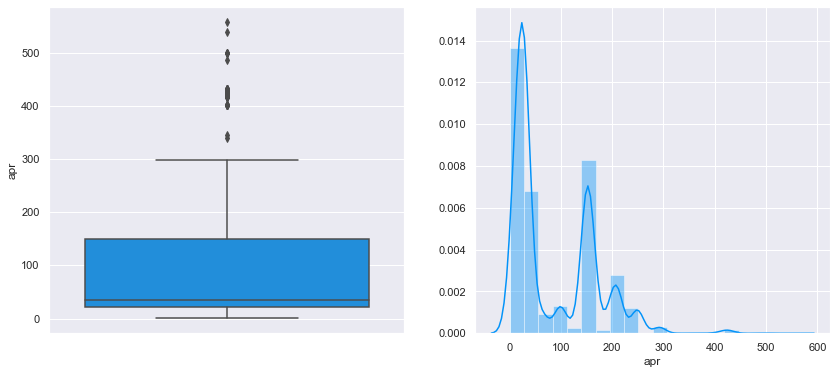

In [23]:
# plot "apr" 
plot_box_dist(merged, 'apr')

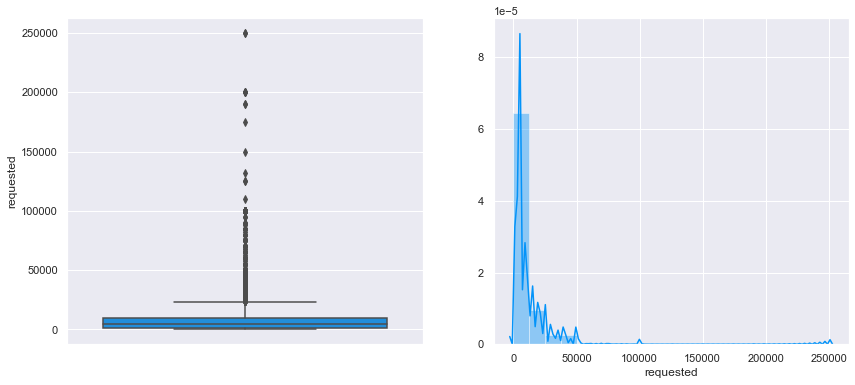

In [24]:
# plot "requsted"
plot_box_dist(merged, 'requested')

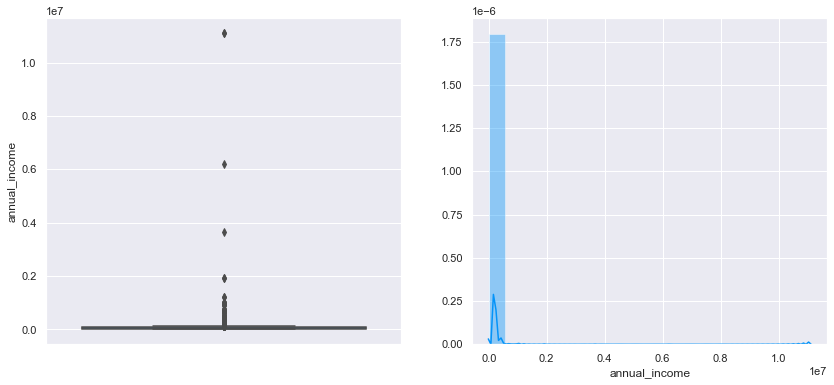

In [25]:
# plot "annual_income"
plot_box_dist(merged, 'annual_income')

Numerical vairables contain a lot of outliers. We can cap the outliers or select models that are robust to outliers.

In [26]:
def plot_value_counts(df, col):
    
    """Display barplot for categoricl variables"""
    
    plt.figure(figsize=(20,8))
    value_counts = df[col].value_counts()
    sns.barplot(value_counts.index, value_counts.values, palette='terrain', alpha=0.6)
    plt.xticks(rotation=45)

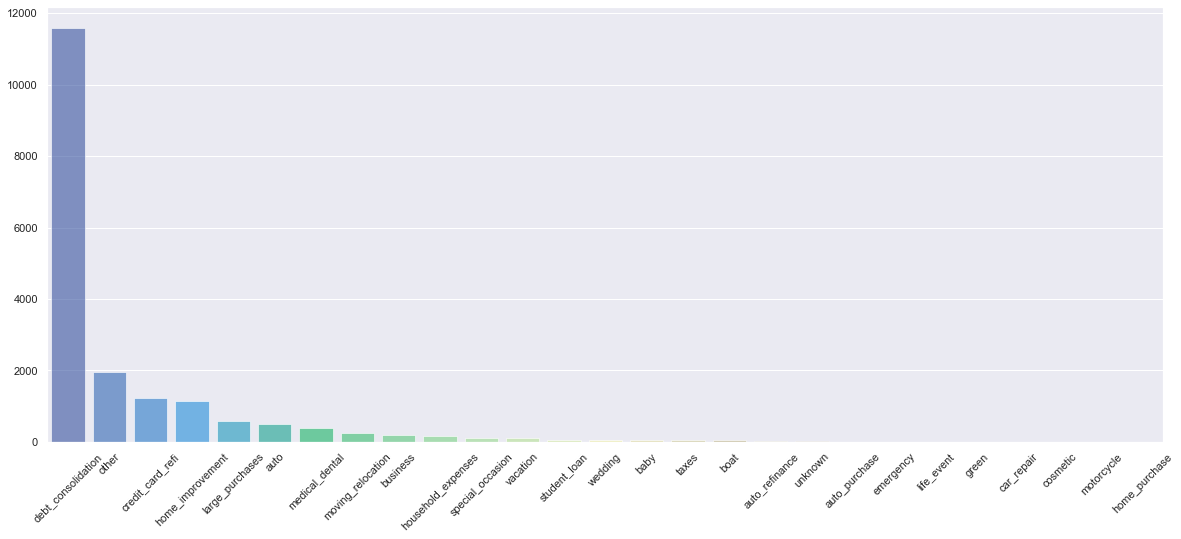

In [27]:
# barplot for "loan purpose"
plot_value_counts(merged, 'loan_purpose')

The most common loan_purpose is debt_consolidation.

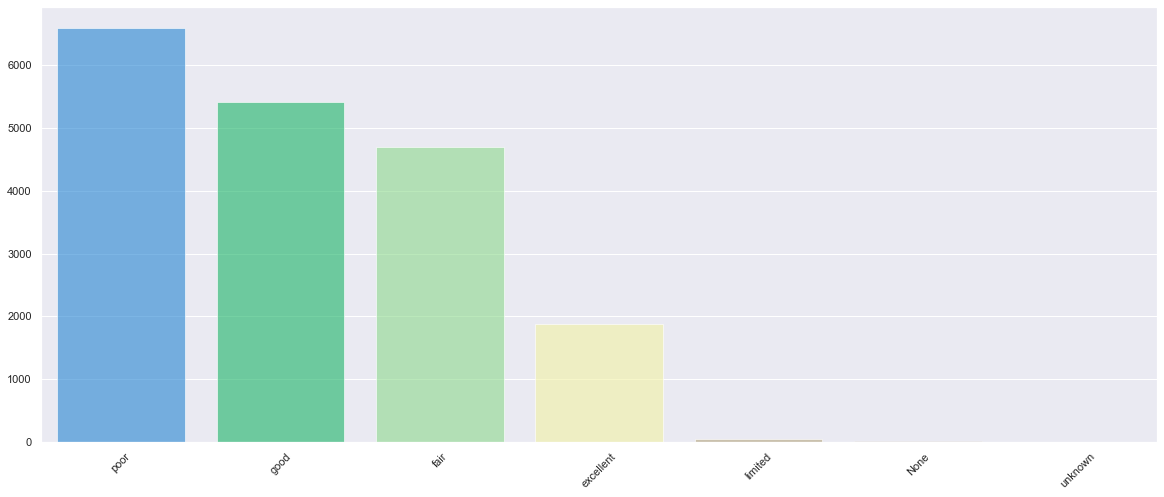

In [28]:
# barplot for credit
plot_value_counts(merged, 'credit')

A large percentage of the leads have poor credit score.

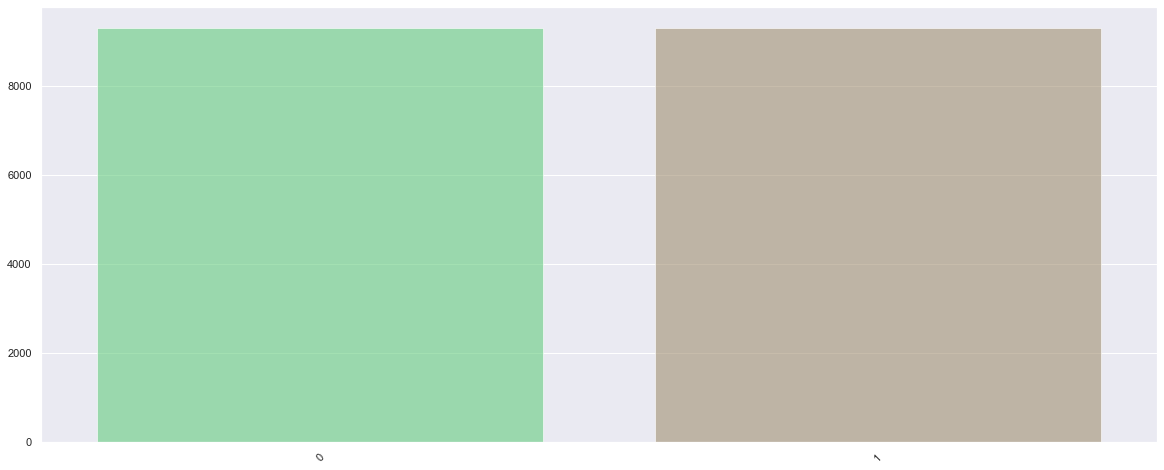

In [29]:
# barplot for the target variable
plot_value_counts(merged, 'clicked_at')

In [30]:
def create_two_kdeplots(df, target_variable, col):
    ''' 
    Makes two kdeplots stacked on one another.
    
    Args:
    
    df(dataframe): pandas dataframe
    col(str): column name
    
    '''
    plt.figure(figsize=(12,7))

    sns.kdeplot(df[df[target_variable]==0][col], 
                label = 'Unclicked Offers', 
                shade = True)
    
    sns.kdeplot(df[df[target_variable]==1][col], 
                label = "Clicked Offers", 
                shade = True)

    plt.xlabel(col)

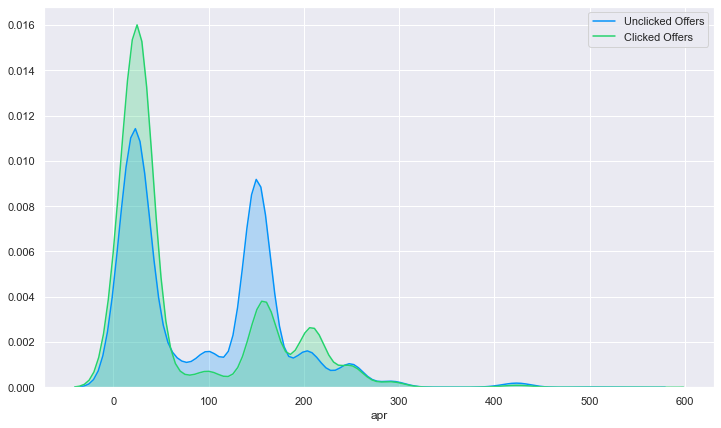

In [31]:
# compare "apr" between clicked offers and unclicked offers
create_two_kdeplots(merged, 'clicked_at',  'apr')

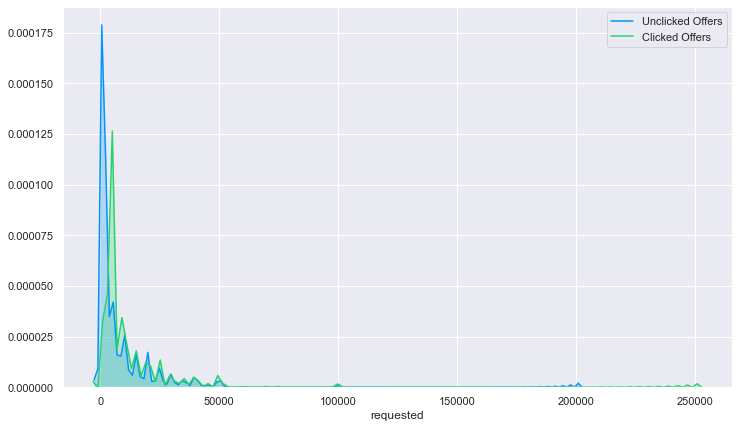

In [32]:
# compare "requested" between clicked offers and unclicked offers
create_two_kdeplots(merged, 'clicked_at',  'requested')

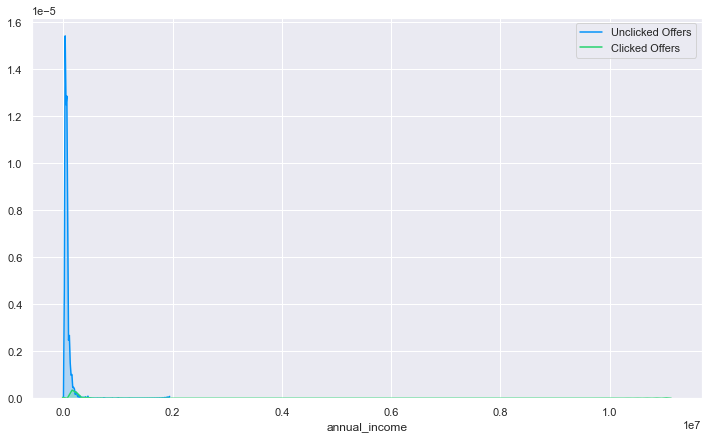

In [33]:
# compare "annual_income" between clicked offers and unclicked offers
create_two_kdeplots(merged, 'clicked_at',  'annual_income')

Seems like the clicked offers occured more often when the requested loan amount is fairly low and apr is low as well.

In [34]:
def plot_target_hue(df, col):
    
    """Barplot of categorical variable with comparision of the target variable counts"""
    
    plt.figure(figsize=(20,9))
    sns.countplot(x=col, hue='clicked_at', 
                  data=df, alpha=0.8)
    plt.xticks(rotation=45)


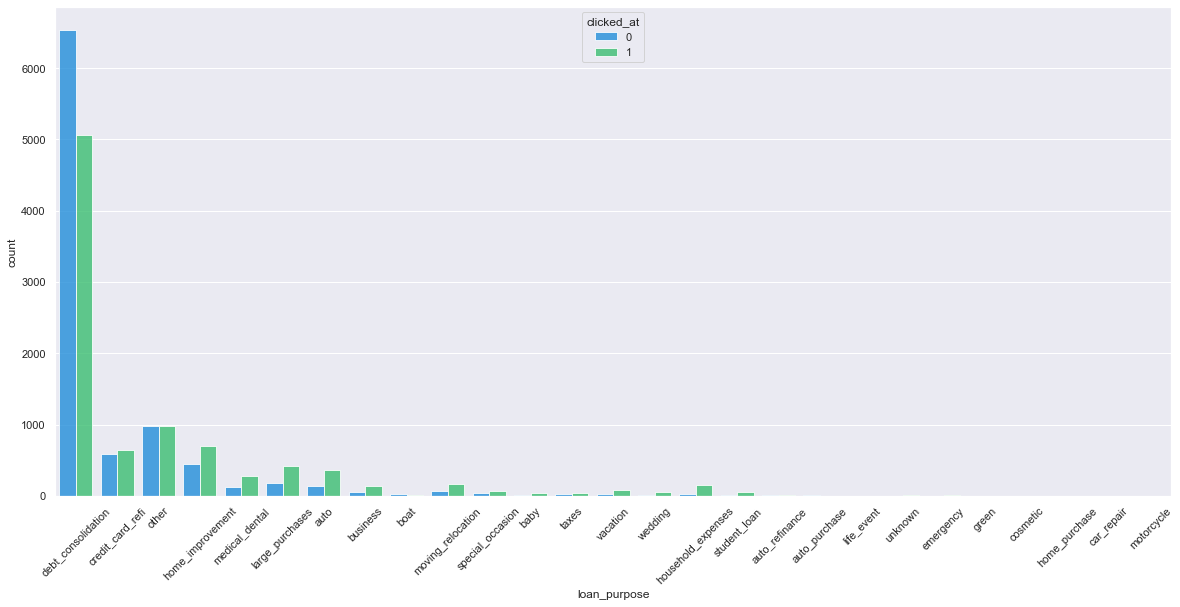

In [35]:
plot_target_hue(merged, 'loan_purpose')

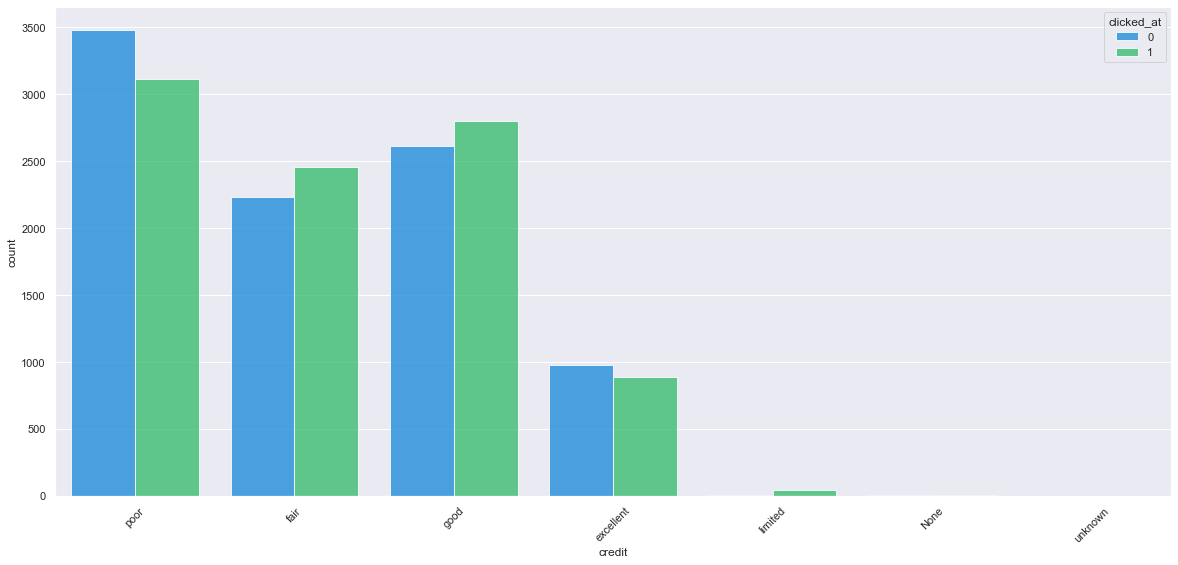

In [36]:
plot_target_hue(merged, 'credit')

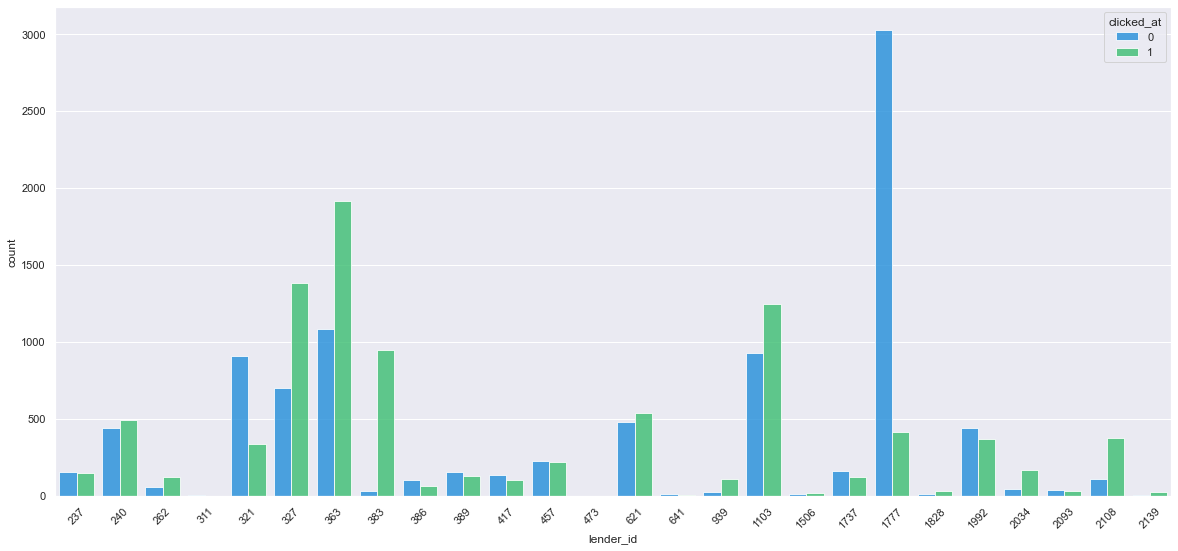

In [37]:
plot_target_hue(merged, 'lender_id')

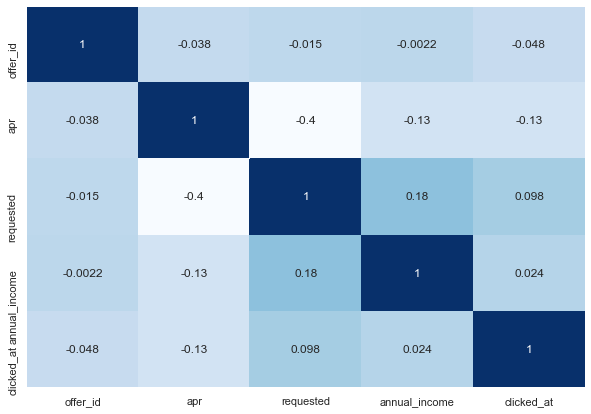

In [38]:
# plot correlation matrix
plt.figure(figsize=(10,7))
matrix = merged.corr()
sns.heatmap(matrix, cbar=False, annot=True, fmt='.2g', cmap='Blues')

# Create Baseline Model

In [39]:
# Create a dataframe with all the features
features = merged[['apr', 'lender_id', 'requested',
                   'loan_purpose', 'credit', 
                   'annual_income']]

# Create target variable series
target = merged['clicked_at']

In [40]:
# Split data into training set and testing set
x_train, x_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    stratify=target,
                                                    random_state=42)

In [41]:
# Display shape of training data
x_train.shape, y_train.shape

((13042, 6), (13042,))

In [42]:
# Display shape of testing data
x_test.shape, y_test.shape

((5590, 6), (5590,))

In [43]:
columns = features.columns
columns

Index(['apr', 'lender_id', 'requested', 'loan_purpose', 'credit',
       'annual_income'],
      dtype='object')

### Baseline Model Approach

We are going to use a naive approach to create a baseline model.
Since the majority class is "0", we are going to predict all the  as 0.

In [44]:
# Create preditions with all 0s
base_pred = [0 for i in range(len(y_test))] 

In [45]:
len(base_pred)

5590

In [46]:
def get_scores(true_labels, predictions):
    """
    Print accuracy score and AUC score.
    
    Args:
    true_labels: an array or a list of ground truth labels
    predictions: an array or a list of predicted labels
    
    """
    acc_score = accuracy_score(true_labels, predictions)
    auc_score = roc_auc_score(true_labels, predictions)
    fpr, tpr, thresholds = roc_curve(true_labels, predictions)
    print(f'Accuracy score is {acc_score:.2f}')
    print(f'AUC score is {auc_score:.2f}')

In [47]:
# using naive approach to predict every entry as 1 (the majority calss)
ns_predictions = [0 for _ in range(len(x_test))]
# find false positive rate and true positive rate using sklearn's roc_curve
ns_fpr, ns_tpr, thresholds = roc_curve(y_test, ns_predictions)

In [48]:
# Display scores
get_scores(y_test, ns_predictions)

Accuracy score is 0.50
AUC score is 0.50


### Target Mean Encoding for Categorical Variables

In [49]:
def target_mean_labels(df, col):
    
    """Group dataset by a variable. Create a dictionary with labels' target mean value."""
    
    labels = df.groupby(col)['clicked_at'].mean().to_dict()

    return labels

def target_mean_encoder(df, col):
    """Encode the labels with its target mean value"""
    labels = target_mean_labels(merged, col)
    df.loc[:, col] = df.loc[:, col].map(labels)
    return df

In [50]:
# Encode categorical variables with target mean value
cat_cols = ['lender_id', 'loan_purpose', 'credit']
for col in cat_cols:
    x_train = target_mean_encoder(x_train, col)
    x_test = target_mean_encoder(x_test, col)

In [51]:
x_train.head(1)

,apr,lender_id,requested,loan_purpose,credit,annual_income
122238,249.00,0.57,700.00,0.44,0.47,30000.00


In [52]:
x_test.head(1)

,apr,lender_id,requested,loan_purpose,credit,annual_income
164954,29.56,0.64,10000.00,0.44,0.52,65000.00


In [53]:
x_test.isnull().sum()

apr              0
lender_id        0
requested        0
loan_purpose     0
credit           0
annual_income    0
dtype: int64

## Correlation Matrix

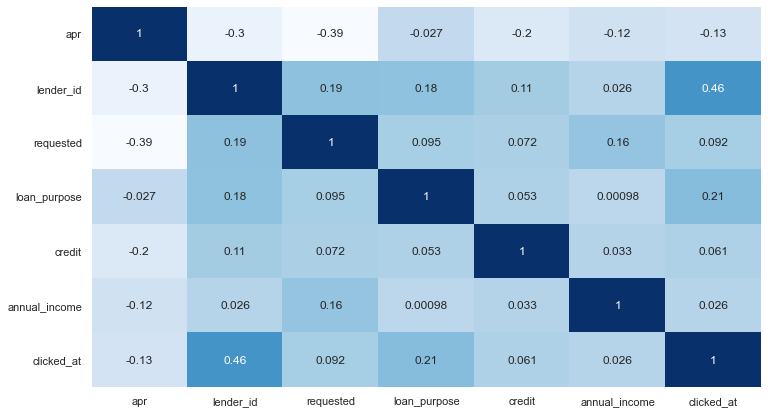

In [54]:
plt.figure(figsize=(12, 7))
scaled_matrix = pd.concat([x_train, y_train], axis=1).corr()
sns.heatmap(scaled_matrix, cbar=False, annot=True, fmt='.2g', cmap='Blues')

After data preprocessing and feature engineering, the correlation matrix shows that the lender_id and the loan_purpose have the strongest correlation with our target variable.

# Model Development

We will be using the following model:

1. Logistic Regression
2. Random Forest Classifier 
3. Gradient Boosting Classifier

On my first and second attempt, I removed outliers and scaled the data. The model performance slightly improved for Logistic Regression but decreased for Random Forest and Gradient Boosting Classifier.
So this time, I decide to keep the outliers and unscaled data.

**Metric selection: Roc-Auc score**

The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [56]:
def select_model(train_X, train_y):

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ['newton-cg', 'lbfgs', 'liblinear'],
                    "penalty": ['l2'],
                    "C": [10, 1.0, 0.1, 0.01]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=42),
            "hyperparameters":
                {
                    "n_estimators": [100],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        },
        {
            "name": "Gradient Boosting Classifier",
            "estimator": GradientBoostingClassifier(random_state=42),
            "hyperparameters":
                {
                    "learning_rate": [0.01, 0.1, 0.2],
                    "min_samples_split": [2, 3, 5],
                    "min_samples_leaf": [1, 5, 8],
                    "max_depth":[3,5,8],
                    "max_features":["log2","sqrt"],
                    "subsample":[0.6, 0.8],
                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))
        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            scoring='roc_auc',
                            n_jobs=-1,
                            cv=3)
        grid.fit(train_X, train_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}".format(model["best_params"]))
        print("Best Estimator: {}".format(model['best_model']))

    return models

In [57]:
select_model(x_train, y_train)

LogisticRegression
------------------
Best Score: 0.7666511651183446
Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Estimator: LogisticRegression(C=0.1, solver='newton-cg')
RandomForestClassifier
----------------------
Best Score: 0.8401336370094334
Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best Estimator: RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=5,
                       random_state=42)
Gradient Boosting Classifier
----------------------------
Best Score: 0.8410668576803987
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'subsample': 0.8}
Best Estimator: GradientBoostingClassifier(max_depth=5, max_features='log2', min_samples_leaf=5,
                           random_state=42, subsample=0.8)


[{'name': 'LogisticRegression',
  'estimator': LogisticRegression(),
  'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
   'penalty': ['l2'],
   'C': [10, 1.0, 0.1, 0.01]},
  'best_params': {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'},
  'best_score': 0.7666511651183446,
  'best_model': LogisticRegression(C=0.1, solver='newton-cg')},
 {'name': 'RandomForestClassifier',
  'estimator': RandomForestClassifier(random_state=42),
  'hyperparameters': {'n_estimators': [100],
   'max_depth': [2, 5, 10],
   'max_features': ['log2', 'sqrt'],
   'min_samples_leaf': [1, 5, 8],
   'min_samples_split': [2, 3, 5]},
  'best_params': {'max_depth': 10,
   'max_features': 'log2',
   'min_samples_leaf': 5,
   'min_samples_split': 2,
   'n_estimators': 100},
  'best_score': 0.8401336370094334,
  'best_model': RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=5,
                         random_state=42)},
 {'name': 'Gradient Boosting Classifier',
  'estimator

### Apply Logistic Regression model on test set

In [58]:
lr_model = LogisticRegression(C=0.01, penalty='l2', solver='newton-cg')

In [59]:
lr_model.fit(x_train, y_train)

LogisticRegression(C=0.01, solver='newton-cg')

In [60]:
lr_preds = lr_model.predict(x_test)

In [61]:
get_scores(y_test, lr_preds)

Accuracy score is 0.69
AUC score is 0.69


### Apply Random Forest model on test set


In [62]:
rfc_model = RandomForestClassifier(max_depth=10, 
                                   max_features='log2', 
                                   min_samples_leaf=5,
                                   random_state=42)

In [63]:
rfc_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=5,
                       random_state=42)

In [64]:
rfc_preds = rfc_model.predict(x_test)

In [65]:
get_scores(y_test, rfc_preds)

Accuracy score is 0.76
AUC score is 0.76


## Apply Gradient Boosting on test set

In [66]:
gbc_model = GradientBoostingClassifier(max_depth=8, 
                                       max_features='log2', 
                                       min_samples_leaf=8,
                                       random_state=42, 
                                       subsample=0.8)

In [67]:
gbc_model.fit(x_train, y_train)

GradientBoostingClassifier(max_depth=8, max_features='log2', min_samples_leaf=8,
                           random_state=42, subsample=0.8)

In [68]:
gbc_preds = gbc_model.predict(x_test)

In [69]:
get_scores(y_test, gbc_preds)

Accuracy score is 0.76
AUC score is 0.76


In [70]:
# build a list of prediction
pred_list = [lr_preds, rfc_preds, gbc_preds]
# build a list of model names
model_list = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']

In [71]:
def plot_roc_curve(true_labels, pred_list, model_list):
    
    """
    Plot ROC curve.
    
    Args:
    true_labels: an array or a list of ground truth labels
    pred_list: a list of predicted labels from different models
    model_list: a list of model names
    
    """
    plt.figure(figsize=(16,12))
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Naive Approach')
    
    for i in range(len(model_list)):
        fpr, tpr, _ = roc_curve(true_labels, pred_list[i])
        plt.plot(fpr, tpr, marker='.', label=model_list[i])
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    # show the legend
    plt.legend()

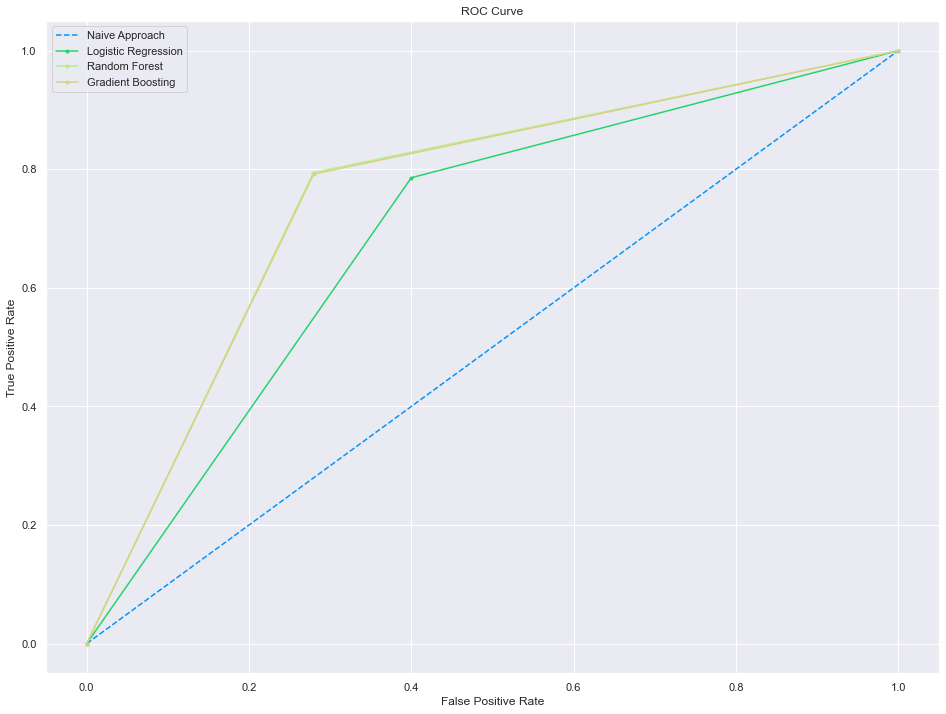

In [72]:
plot_roc_curve(y_test, pred_list, model_list)

## Model Selection

From the results and the roc curve,  we can see that the **Gradient Boosting** model has the highest AUC score. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

We will use the Gradient Boosting model for our web app.

In [73]:
# Save Model Using Pickle
import pickle

# save the model to disk
filename = 'gbc_model.sav'
pickle.dump(gbc_model, open(filename, 'wb'))

In [74]:
# Save merged table to app_data.db
engine = create_engine('sqlite:///app_data.db', encoding = 'UTF-8')
merged.to_sql('app_data', engine, if_exists='replace', index=False)

### Conclusion:

If time is not an issue, we can still improve the model performance by testing the following methods:

1. Create more features using the variables that are highly correlated or have the highest feature importance.

2. Test other machine learning algorithms.

3. Keep on fine tuning hyper-parameters.

4. We used downsampling to balance the dataset. Alternatively, we can use SMOTE to synthesize new examples for the minority data.
